# import

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

# function

In [2]:
def findMaxContourWithOtsu(img):
    
    # グレースケール変換
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 方法2 （OpenCVで実装）   
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_OTSU+cv2.THRESH_OTSU)    

    thresh = cv2.bitwise_not(thresh)
  
    # Find Contours
    _, contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    contours.sort(key=cv2.contourArea, reverse=True)
    
    return contours[0]


def findMaxContour(img):
    
    # グレースケール変換
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, 0)    
  
    # Find Contours
    _, contours, _ = cv2.findContours(gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours.sort(key=cv2.contourArea, reverse=True)
    
    return contours[0]

def selective_search(img, mode):
    
    # speed-up using multithreads
    cv2.setUseOptimized(True);
    cv2.setNumThreads(4);
 
    # create Selective Search Segmentation Object using default parameters
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
     
    # set input image on which we will run segmentation
    ss.setBaseImage(img)
 
    # Switch to fast but low recall Selective Search method
    if (mode == 'f'):
        ss.switchToSelectiveSearchFast()
 
    # Switch to high recall but slow Selective Search method
    elif (mode == 'q'):
        ss.switchToSelectiveSearchQuality()
    # if argument is neither f nor q print help message
    else:
        print(__doc__)
        sys.exit(1)
 
    # run selective search segmentation on input image
    rects = ss.process()
    print('Total Number of Region Proposals: {}'.format(len(rects)))    
    
    return rects

def grabcut(img, num, rect):
    
    mask = np.zeros(img.shape[:2], np.uint8) # マスク用領域
    bgModel = np.zeros((1, 65), np.float64) # 背景GMMモデル
    fgModel = np.zeros((1, 65), np.float64) # 前景GMMモデル
    cv2.grabCut(img, mask, rect, bgModel, fgModel, num, cv2.GC_INIT_WITH_RECT) # イテレーション回数5
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype(np.uint8) # maskの値が1の部分のみ残して0クリア
    return img * mask2[:, :, np.newaxis] # カラーチャンネルの分だけbroadcastしつつ掛け算、結果として1の領域のみ残す

# 二値化（大津）

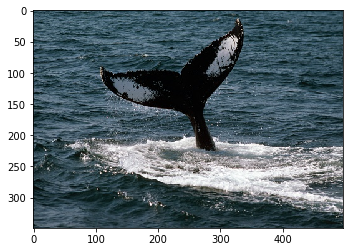

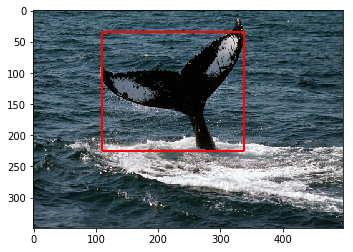

(<matplotlib.image.AxesImage at 0x23d6cd8cc88>, None)

In [173]:
img = cv2.imread('C:/Users/shihnkawa/prj/whale/images/G0010750.JPG')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.show()

# グレースケール変換
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# 方法2 （OpenCVで実装）   
blur = cv2.GaussianBlur(gray, (1, 1), 1)
_, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_OTSU+cv2.THRESH_OTSU)    

thresh = cv2.bitwise_not(thresh) 

# 結果を出力
# plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)), plt.show()

# Find Contours
_, contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
contours.sort(key=cv2.contourArea, reverse=True)

x, y, w, h = cv2.boundingRect(contours[0])
cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 2)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.show()

# 移動しながら回転させる

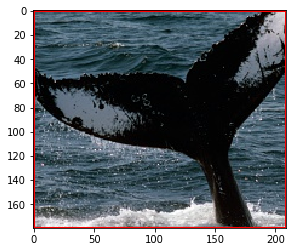

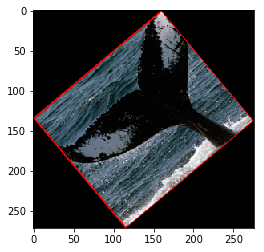

(<matplotlib.image.AxesImage at 0x23d5efacda0>, None)

In [7]:
# トリミング
img_view = img[y:y+h, x:x+w]
plt.imshow(cv2.cvtColor(img_view, cv2.COLOR_BGR2RGB)), plt.show()

h, w = img_view.shape[:2]
size = (w, h)

# 回転角の指定
angle = 40
angle_rad = angle/180.0*np.pi

# 回転後の画像サイズを計算
w_rot = int(np.round(h*np.absolute(np.sin(angle_rad))+w*np.absolute(np.cos(angle_rad))))
h_rot = int(np.round(h*np.absolute(np.cos(angle_rad))+w*np.absolute(np.sin(angle_rad))))
size_rot = (w_rot, h_rot)

# 元画像の中心を軸に回転する
center = (w/2, h/2)
scale = 1.0
rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)

# 平行移動を加える (rotation + translation)
affine_matrix = rotation_matrix.copy()
affine_matrix[0][2] = affine_matrix[0][2] -w/2 + w_rot/2
affine_matrix[1][2] = affine_matrix[1][2] -h/2 + h_rot/2

# アフィン変換
img_rot = cv2.warpAffine(img_view, affine_matrix, size_rot, flags=cv2.INTER_CUBIC)

plt.imshow(cv2.cvtColor(img_rot, cv2.COLOR_BGR2RGB)), plt.show()

# New heading

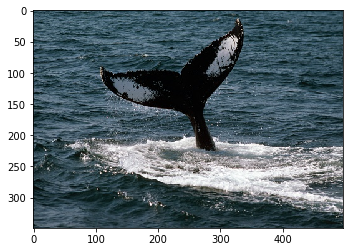

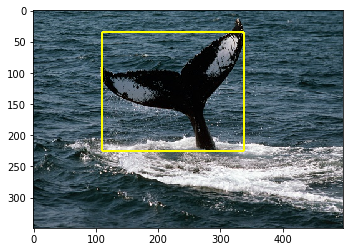

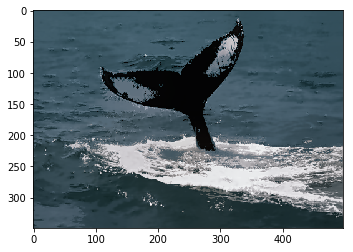

Total Number of Region Proposals: 1045
[111   9 227 217]
[111   8 230 218]
[112  13 226 210]
[115   5 224 221]
[111   8 230 218]


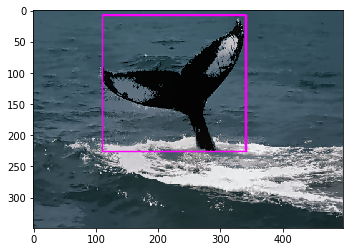

(<matplotlib.image.AxesImage at 0x188b48b2b00>, None)

In [41]:
img = cv2.imread('C:/Users/shihnkawa/prj/whale/images/G0010750.JPG')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.show()

cnt = findMaxContourWithOtsu(img)
x, y, w, h = cv2.boundingRect(cnt)
cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 255), 2)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.show()

# cx, cy = x + w // 2, y + h // 2
# range_w, range_h = int(w * 1.1), int(h * 1.1)

# half_w, half_h = range_w // 2, range_h // 2
# x1, y1, x2, y2 = cx - half_w, cy - half_h, cx + half_w, cy + half_h 

x1, y1, x2, y2 = x, y, x + w, y + h
cx1, cy1 = x + w // 2, y + h // 2

img = cv2.imread('C:/Users/shihnkawa/prj/whale/images/G0010750.JPG')
# 平均値シフト法で領域分割 
img = cv2.pyrMeanShiftFiltering(img, 32, 32)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.show()

# selective search
rects = selective_search(img, 'f')

img_h, img_w = img.shape[:2]

max_area = None
max_rect = None

# itereate over all the region proposals
for i, rect in enumerate(rects):
  
    # draw rectangle for region proposal till numShowRects
    x, y, w, h = rect
    area = w * h

    cx, cy = x + w // 2, y + h // 2

    if x == 0 or y == 0:
        continue

    if abs(cx1 - cx) > 20 or abs(cy1 - cy) > 20:
        continue
        
    if x < x1 or x2 > x + w:
        continue
    
#     if y < y1 or y2 > y + h:
        continue
        
    # distorted rects
#     if w / h > 1.2 or h / w > 1.2:
#         continue 
    print(rect)
    if max_area == None:
        max_area = area 
        max_rect = rect

    else:
        if max_area < area:
            max_area = area 
            max_rect = rect
  
x, y, w, h = max_rect
print(max_rect)
cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 255), 2, cv2.LINE_AA)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.show()

# selective search その２

In [108]:
import ipywidgets as widgets
from IPython.display import display

scale = widgets.Text(value='', placeholder='scale', description='scale:')
textbox=widgets.Text(value='', placeholder='imagePath', description='path:')
input_x = widgets.IntText(value=None, placeholder='x', description='x:')
input_y = widgets.IntText(value=None, placeholder='y', description='y:')
input_w = widgets.IntText(value=None, placeholder='w', description='w:')
input_h = widgets.IntText(value=None, placeholder='h', description='h:')
display(input_x, input_y, input_w, input_h, scale, textbox)

IntText(value=0, description='x:')

IntText(value=0, description='y:')

IntText(value=0, description='w:')

IntText(value=0, description='h:')

Text(value='', description='scale:', placeholder='scale')

Text(value='', description='path:', placeholder='imagePath')

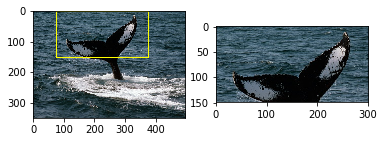

38 45 206 105


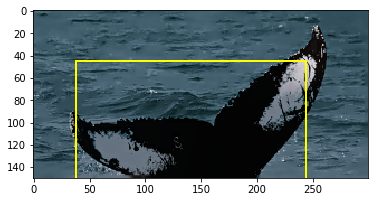

Total Number of Region Proposals: 328
328
38 43 206 107
36 45 208 105
38 15 225 135
36 15 235 135
[ 36  15 235 135]


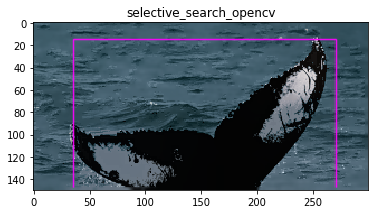

12588 (35, 20, 227, 129)
1


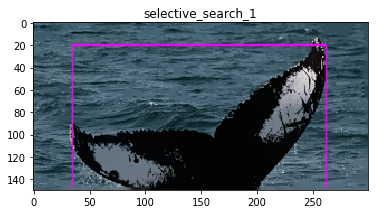

(Text(0.5,1,'selective_search_1'),
 None)

In [297]:
# img = cv2.imread('C:/Users/shihnkawa/prj/whale/images/G0010064.JPG')
# 75 0 300 150

import matplotlib.pyplot as plt
import selectivesearch
import cv2

# loading astronaut image
img = cv2.imread(textbox.value)
img_copy = img.copy()

cv2.rectangle(img_copy, (input_x.value, input_y.value), (input_x.value + input_w.value, input_y.value + input_h.value), (0, 255, 255), 2)
plt.subplot(1, 2, 1), plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))

img = img[input_y.value:input_y.value+input_h.value, input_x.value:input_x.value+input_w.value]
plt.subplot(1, 2, 2), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.show()

#
img = cv2.pyrMeanShiftFiltering(img, 21, 21)
cnt = findMaxContourWithOtsu(img)
x, y, w, h = cv2.boundingRect(cnt)
print(x, y, w, h)
cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 255), 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.show()

img = cv2.imread(textbox.value)
img = img[input_y.value:input_y.value+input_h.value, input_x.value:input_x.value+input_w.value]
cv2.imwrite('test.JPG', img)

# selective search
img = cv2.imread('test.JPG')
img = cv2.pyrMeanShiftFiltering(img, 21, 21)
rects = selective_search(img, 'f')

img_h, img_w = img.shape[:2]
cx1, cy1 = 0 + img_w // 2, 0 + img_h // 2
max_area = None
max_rect = None

print(len(rects))
# itereate over all the region proposals
for i, rect in enumerate(rects):
    # draw rectangle for region proposal till numShowRects
    x, y, w, h = rect
    area = w * h
    cx, cy = x + w // 2, y + h // 2

    if x == 0 or y == 0:
        continue

    if abs(cx1 - cx) > 10:
        continue
    
    if area < 20000:
        continue
    
    if max_area == None:
        max_area = area 
        max_rect = rect

    else:
        if max_area < area:
            max_area = area 
            max_rect = rect
    
    print(x, y, w, h)
#     img_copy = img.copy()
#     cv2.rectangle(img_copy, (x, y), (x+w, y+h), (255, 0, 255), 1, cv2.LINE_AA)
#     plt.title('selective_search_opencv'), plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)), plt.show()

x, y, w, h = max_rect
print(max_rect)
cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 255), 1, cv2.LINE_AA)
plt.title('selective_search_opencv'), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.show()

img = cv2.imread('test.JPG')
img = cv2.pyrMeanShiftFiltering(img, 16, 16)

# perform selective search
_, regions = selectivesearch.selective_search(img, scale=int(scale.value), sigma=0.9, min_size=3000)

candidates = set()
max_area = None
max_rect = None

for r in regions:
    # excluding same rectangle (with different segments)
    if r['rect'] in candidates:
        continue

    x, y, w, h = r['rect']
    area = w * h
    cx, cy = x + w // 2, y + h // 2

    if x == 0 or y == 0:
        continue

    if abs(cx1 - cx) > 20 or abs(cy1 - cy) > 20:
        continue
        
#     if x > x1 or x2 > x + w:
#         continue
    
#     if y > y1 or y2 > y + h:
#         continue    
        
    # distorted rects
#     if w / h > 1.2 or h / w > 1.2:
#         continue

    if max_area == None:
        max_area = area 
        max_rect = r['rect']

    else:
        if max_area < area:
            max_area = area 
            max_rect = r['rect']
    print(r['size'],r['rect'])
    candidates.add(r['rect'])
print(len(candidates))
[cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 255), 1, cv2.LINE_AA) for x, y, w, h in candidates]

# x,y,w,h = max_rect
# cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 255), 1, cv2.LINE_AA)

plt.title('selective_search_1'), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.show()

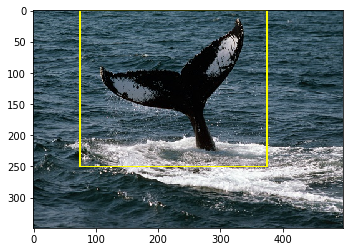

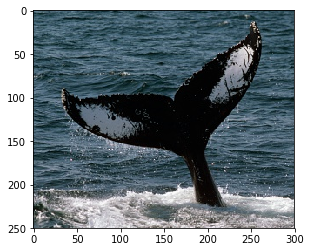

35 35 228 190


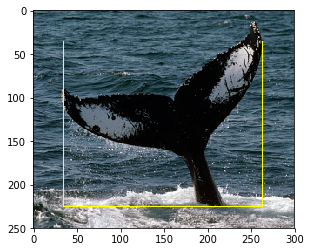

Total Number of Region Proposals: 768
768
[ 38  14 262 212]


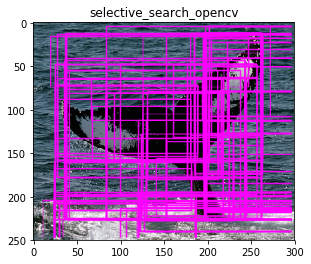

SystemExit: 

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2969: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [130]:
# img = cv2.imread('C:/Users/shihnkawa/prj/whale/images/G0010064.JPG')
from __future__ import (
    division,
    print_function,
)

import matplotlib.pyplot as plt
import selectivesearch
import cv2

# loading astronaut image
img = cv2.imread(textbox.value)
img_copy = img.copy()

cv2.rectangle(img_copy, (input_x.value, input_y.value), (input_x.value + input_w.value, input_y.value + input_h.value), (0, 255, 255), 2)
plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)), plt.show()

img = img[input_y.value:input_y.value+input_h.value, input_x.value:input_x.value+input_w.value]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.show()

# 平均値シフト法で領域分割 
# img = cv2.pyrMeanShiftFiltering(img, 32, 32, 2)
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.show()

# 
cnt = findMaxContourWithOtsu(img)
x, y, w, h = cv2.boundingRect(cnt)
print(x, y, w, h)
cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 255), 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.show()

x1, y1, x2, y2 = x, y-10, x + w, y + h
cx1, cy1 = x + w // 2, y + h // 2


img = cv2.imread(textbox.value)
img = img[input_y.value:input_y.value+input_h.value, input_x.value:input_x.value+input_w.value]

# 平均値シフト法で領域分割 
# img = cv2.pyrMeanShiftFiltering(img, 32, 32)

# selective search
rects = selective_search(img, 'f')

img_h, img_w = img.shape[:2]

max_area = None
max_rect = None

print(len(rects))
# itereate over all the region proposals
for i, rect in enumerate(rects):
    # draw rectangle for region proposal till numShowRects
    x, y, w, h = rect
    area = w * h
    cx, cy = x + w // 2, y + h // 2

    if x == 0 or y == 0:
        continue

#     if abs(cx1 - cx) > 10:
#         continue
        
#     if y2 > y + h:
#         continue    
    if area < 6000:
        continue
        
    if max_area == None:
        max_area = area 
        max_rect = rect

    else:
        if max_area < area:
            max_area = area 
            max_rect = rect
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 255), 1, cv2.LINE_AA)
    
x, y, w, h = max_rect
print(max_rect)
cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 255), 1, cv2.LINE_AA)
plt.title('selective_search_opencv'), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.show()

import sys
sys.exit()

img = cv2.imread(textbox.value)
img = cv2.pyrMeanShiftFiltering(img, 32, 32)

# perform selective search
_, regions = selectivesearch.selective_search(img, scale=int(scale.value), sigma=0.9, min_size=3000)

candidates = set()
max_area = None
max_rect = None

print(x, y, x+w, y+h)
for r in regions:
    # excluding same rectangle (with different segments)
    if r['rect'] in candidates:
        continue

    x, y, w, h = r['rect']
    area = w * h
    cx, cy = x + w // 2, y + h // 2

    if x == 0 or y == 0:
        continue

    if abs(cx1 - cx) > 20 or abs(cy1 - cy) > 20:
        continue
        
#     if x > x1 or x2 > x + w:
#         continue
    
#     if y > y1 or y2 > y + h:
#         continue    
        
    # distorted rects
#     if w / h > 1.2 or h / w > 1.2:
#         continue

    if max_area == None:
        max_area = area 
        max_rect = r['rect']

    else:
        if max_area < area:
            max_area = area 
            max_rect = r['rect']
    print(r['size'],r['rect'])
    candidates.add(r['rect'])

[cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 255), 2, cv2.LINE_AA) for x, y, w, h in candidates]
plt.title('selective_search_1'), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.show()

img = cv2.imread(textbox.value)
img = cv2.pyrMeanShiftFiltering(img, 64, 64)

rect = x, y, x+w, y+h
img = grabcut(img, 2, rect)
plt.title('grabcut'), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.show()

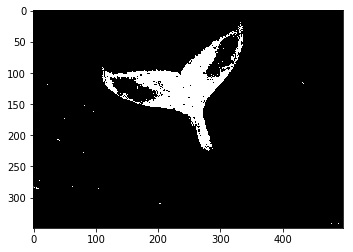

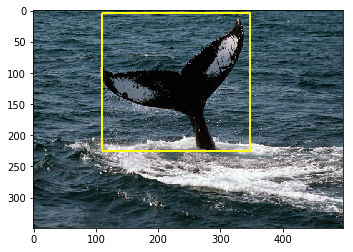

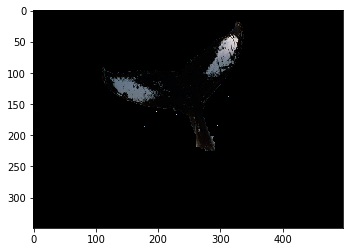

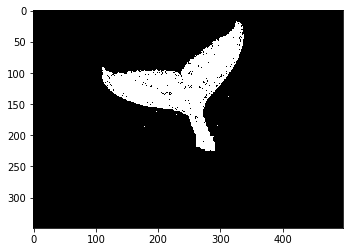

18


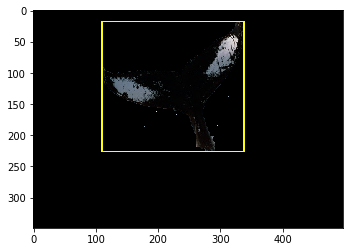

True

In [204]:
img = None
img = cv2.imread('C:/Users/shihnkawa/prj/whale/images/G0010750.JPG') # G0010803.JPG.png

cnt = findMaxContourWithOtsu(img)
x, y, w, h = cv2.boundingRect(cnt)

img_view = img.copy()
cv2.rectangle(img_view, (x, y-30), (x + w+10, y + h), (0, 255, 255), 2)
plt.imshow(cv2.cvtColor(img_view, cv2.COLOR_BGR2RGB)), plt.show()

rect = (x, y -30, x + w, y + h)
img = grabcut(img, 1, rect)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.show()

cnt1 = findMaxContour(img)
x, y, w, h = cv2.boundingRect(cnt1)

cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 255), 2)
print(y)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.show()
cv2.imwrite('test.JPG', img)

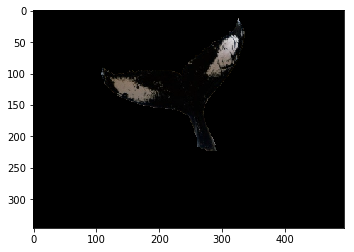

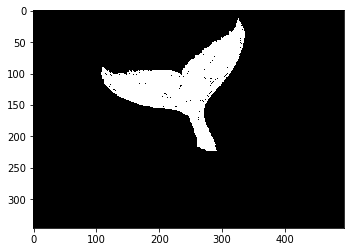

13


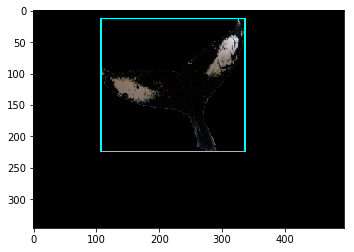

(<matplotlib.image.AxesImage at 0x23d6cda4d30>, None)

In [203]:
img = cv2.imread('G0010803.JPG.png')
plt.imshow(img), plt.show()

cnt1 = findMaxContour(img)
x, y, w, h = cv2.boundingRect(cnt1)
cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 255), 2)
print(y)
plt.imshow(img), plt.show()

# img = cv2.imread('C:/Users/shihnkawa/prj/whale/images/G0010803.JPG.png')
# plt.imshow(img), plt.show()

# cnt1 = findMaxContour(img)
# x, y, w, h = cv2.boundingRect(cnt1)
# cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 255), 2)
# print(y)
# plt.imshow(img), plt.show()

# New heading

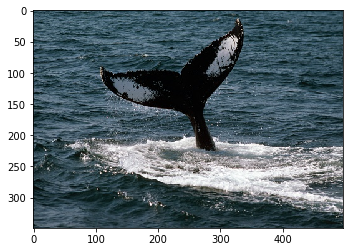

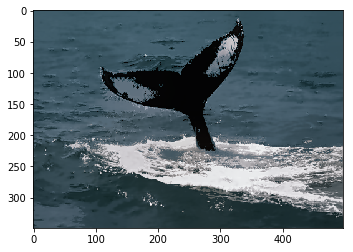

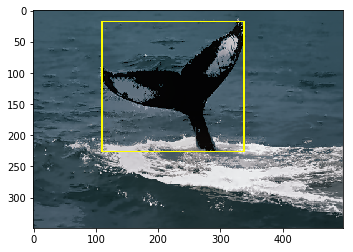

(<matplotlib.image.AxesImage at 0x188b30a6320>, None)

In [23]:
# 入力画像の読み込み
img = cv2.imread('C:/Users/shihnkawa/prj/whale/images/G0010750.JPG')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.show()

# 平均値シフト法で領域分割
img = cv2.pyrMeanShiftFiltering(img, 32, 32)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.show()

cnt = findMaxContourWithOtsu(img)
x, y, w, h = cv2.boundingRect(cnt)
cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 255), 2)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.show()

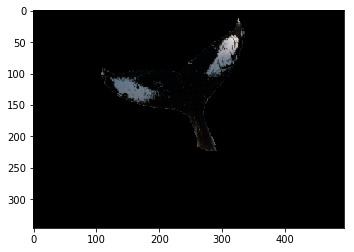

-19.620210647583008
[[  0.94193907  -0.33578385  61.32156676]
 [  0.33578385   0.94193907 -74.83519642]]


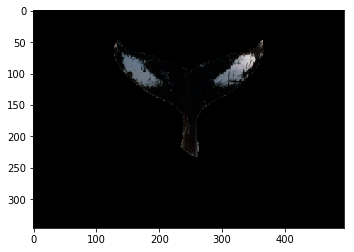

In [10]:
img = cv2.imread('C:/Users/shihnkawa/G0010803.JPG.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.show()

cnt = findMaxContour(img)
    
rows, cols = img.shape[:2]
rect = cv2.minAreaRect(cnt)
center = rect[0]
angle = rect[2]

print(angle)
rot = cv2.getRotationMatrix2D(center, angle, 1)
print(rot)
img = cv2.warpAffine(img, rot, (cols,rows))

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# 回転を考慮した外接矩形を利用した水平補正

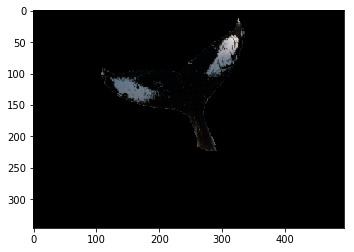

-19.620210647583008
[[  0.94193907  -0.33578385  61.32156676]
 [  0.33578385   0.94193907 -74.83519642]]


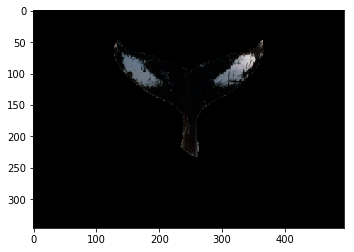

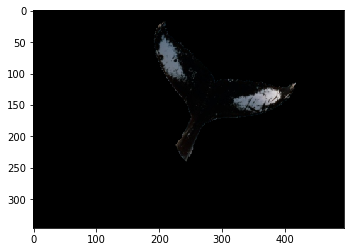

25.334274291992188
[[   0.90382674    0.42789861  -38.08900254]
 [  -0.42789861    0.90382674  130.16621292]]


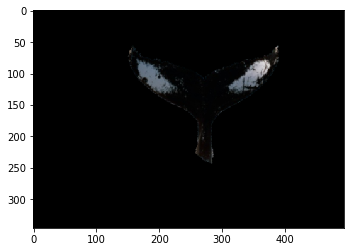

In [27]:
img = cv2.imread('C:/Users/shihnkawa/G0010803.JPG.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.show()
rows, cols = img.shape[:2]

cnt = findMaxContour(img)
rect = cv2.minAreaRect(cnt)
center = rect[0]

if -45 < rect[2]:
    angle = rect[2]
else:
    angle = 90 + rect[2]

print(angle)
rot = cv2.getRotationMatrix2D(center, angle, 1)
print(rot)
img = cv2.warpAffine(img, rot, (cols,rows))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.show()

img = cv2.imread('C:/Users/shihnkawa/G0010803.JPG.png')
M = cv2.getRotationMatrix2D((cols/2,rows/2),-45,1)
img = cv2.warpAffine(img,M,(cols,rows))

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.show()

cnt = findMaxContour(img)
rect = cv2.minAreaRect(cnt)
center = rect[0]

if -45 > rect[2]:
    angle = 90 + rect[2]
else:
    angle = rect[2]

print(angle)
rot = cv2.getRotationMatrix2D(center, angle, 1)
print(rot)
img = cv2.warpAffine(img, rot, (cols,rows))

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))